In [727]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [728]:
# import sys

# sys.path.insert(1, '/kaggle/input/mymodules')

import my_module

In [729]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

all_data = pd.concat([train, test], ignore_index=True)
df = all_data.copy(deep=True)

df.tail()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2914         160       RM        21.00     1936   Pave   NaN      Reg   
2915         160       RM        21.00     1894   Pave   NaN      Reg   
2916          20       RL       160.00    20000   Pave   NaN      Reg   
2917          85       RL        62.00    10441   Pave   NaN      Reg   
2918          60       RL        74.00     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
2914         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2915         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2916         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2917         Lvl    AllPub    Inside  ...        0    NaN  MnPrv        Shed   
2918         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
2914       0      6    2006        WD         Normal        NaN  
2915       0      4    2006        WD        Abnorml        NaN  
2916       0      9    2006        WD        Abnorml        NaN  
2917     700      7    2006        WD         Normal        NaN  
2918       0     11    2006        WD         Normal        NaN  

[5 rows x 80 columns]

<a id='1'> </a>

# 1. EDA


Let's delete all columns with a lot of nan values


In [730]:
df = my_module.delete_nan_column(df, 0.25)

In [731]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

# 1.1 Numeric features


In [732]:
px.imshow(df.corr(), color_continuous_scale=cm, width=1000, height=1000)

First of all, I'm going to work with the features which are highly correlated with SalePrice.

Some of these features are correlated with each other, so I'm going to keep one of them and drop the other. For instance:

- YearBuilt and GarageYrBlt
- GarageArea and GarageCars


In [733]:
numeric_features = df.select_dtypes(include=["float64", "int64"]).columns

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

Let's examine ditributions and try to find obvious outliers


In [734]:
# df[numeric_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Select the most correlated features


In [735]:
numeric_corr_features = my_module.get_corr_features(
    df[numeric_features].corr()["SalePrice"], 0.25
)

In [736]:
for_plotting = [
    "OverallQual",
    "YearBuilt",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "SalePrice",
]

# sns.pairplot(df[for_plotting + ["Train_test"]], diag_kind="kde", hue="Train_test")

There is a significant outlier.


In [737]:
df[df["1stFlrSF"] > 4500][numeric_corr_features]

LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
1298       313.00    63887           10       2008          2008      796.00   
2549       128.00    39290           10       2008          2009     1224.00   

      BsmtFinSF1  TotalBsmtSF  1stFlrSF  2ndFlrSF  ...  FullBath  HalfBath  \
1298     5644.00      6110.00      4692       950  ...         2         1   
2549     4010.00      5095.00      5095         0  ...         2         1   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
1298            12           3      2008.00        2.00     1418.00   
2549            15           2      2008.00        3.00     1154.00   

      WoodDeckSF  OpenPorchSF  SalePrice  
1298         214          292  160000.00  
2549         546          484        NaN  

[2 rows x 21 columns]

1298 is the one. All positive correlated features are quite high, but the price is relatively low. I'll just delete it.


In [738]:
df.drop([1298], inplace=True)

### YearBuilt/YearRemodAdd


I combined YearBuilt and YearRemodAdd in a column


In [739]:
df["YearBuilt/Remod"] = df["YearBuilt"].copy()
df.loc[df["YearBuilt"] > 1950, "YearBuilt/Remod"] = df.loc[
    df["YearBuilt"] > 1950, "YearRemodAdd"
]

In [740]:
px.histogram(df, x="YearBuilt/Remod", color="Train_test")

In [741]:
df.loc[df["YearBuilt/Remod"] < 1895, "YearBuilt/Remod"] = 1895

### GarageYrlBlt


In [742]:
px.histogram(df, x="GarageYrBlt", y="YearBuilt/Remod", color="Train_test")

In [743]:
px.scatter(df, x="GarageYrBlt", y="YearBuilt/Remod", color="Train_test")

In [744]:
df.loc[df["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

In [745]:
px.scatter(df, x="GarageYrBlt", y="SalePrice")

In [746]:
df.loc[df["GarageYrBlt"].isnull(), "GarageYrBlt"] = df["YearBuilt/Remod"]

### OverallCond


Overall Cond has low correlation, but it effects the average price.


In [747]:
px.histogram(df, x="OverallCond", y="SalePrice", histfunc="avg")

# Clipping


One of the ways to deal with outliers is clipping. We change extremely large or small values to be closer to the average values. I only work with the features which don't include many zeros.


In [748]:
df.loc[df["SalePrice"] > 480000, "SalePrice"] = 480000
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950
df.loc[df["GarageCars"] > 3, "GarageCars"] = 3
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250
df.loc[df["GrLivArea"] > 2900, "GrLivArea"] = 2900
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500
df.loc[df["FullBath"] == 0, "FullBath"] = 1
df.loc[df["FullBath"] == 4, "FullBath"] = 3
df.loc[df["HalfBath"] == 2, "HalfBath"] = 1
df.loc[df["Fireplaces"] > 2, "Fireplaces"] = 2
df.loc[df["LotFrontage"] > 150, "LotFrontage"] = 150
df.loc[df["LotArea"] > 50000, "LotArea"] = 50000
df.loc[df["TotRmsAbvGrd"] > 12, "TotRnsAbvGrd"] = 12

# 1.2 Categorical features


In [749]:
cat_features = df.select_dtypes(include=["object"]).columns
df[cat_features] = df[cat_features].fillna("NO")
cat_pred_features = []

In [750]:
cat_features

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'Train_test'],
      dtype='object')

## Quality


In [751]:
quals = [
    "ExterQual",
    "BsmtQual",
    "KitchenQual",
    "GarageQual",
    "FireplaceQu",
    "HeatingQC",
]

figs = []

for q in quals:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    # figs.append(
    #     px.scatter(df, x=q, y="SalePrice", height=300, width=600)
    # )
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

We see, that higher quality means the higher average price. Let's convert categories to numbers. Good and excellent get higher values, because they are few and still effect the average price significantly


In [752]:
quality = dict(zip(["NO", "Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 6, 12]))
df[quals] = df[quals].replace({col: quality for col in quals})
cat_pred_features.extend(quals)

In [753]:
px.imshow(df[quals + ["SalePrice"]].corr(), color_continuous_scale=cm)

## Condition


In [754]:
conds = [col for col in cat_features if "Cond" in col]

figs = []

for q in conds:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    # figs.append(
    #     px.scatter(df, x=q, y="SalePrice", height=300, width=600)
    # )
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

Extremely imbalanced features, without high correlation with average price. I skip them


## Type of house


In [755]:
types = ["MSZoning", "BldgType", "HouseStyle", "GarageType"]

figs = []

for q in types:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    # figs.append(
    #     px.scatter(df, x=q, y="SalePrice", height=300, width=600)
    # )
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

In [756]:
msz = {"C (all)": 0, "RH": 2, "RM": 2, "RL": 4, "NO": 4, "FV": 5}

df.replace({"MSZoning": msz}, inplace=True)
cat_pred_features.append("MSZoning")

In [757]:
hs = {
    "1.5Unf": 0,
    "1.5Fin": 2,
    "SFoyer": 2,
    "SLvl": 3,
    "2.5Unf": 3,
    "1Story": 4,
    "2Story": 6,
    "2.5Fin": 6,
}


df["HouseStyle"].replace(hs, inplace=True)
cat_pred_features.append("HouseStyle")

In [758]:
garage = {
    "NO": 0,
    "CarPort": 0,
    "Detchd": 1,
    "Basment": 2,
    "2Types": 2,
    "Attchd": 3,
    "BuiltIn": 5,
}

df["GarageType"].replace(garage, inplace=True)
cat_pred_features.append("GarageType")

In [759]:
df[["MSZoning", "HouseStyle", "GarageType", "SalePrice"]].corr()

MSZoning  HouseStyle  GarageType  SalePrice
MSZoning        1.00        0.16        0.37       0.34
HouseStyle      0.16        1.00        0.27       0.30
GarageType      0.37        0.27        1.00       0.51
SalePrice       0.34        0.30        0.51       1.00

## Lot characteristics


In [760]:
lot_features = ["LotShape", "LandContour", "LotConfig", "LandSlope"]

figs = []

for q in lot_features:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    # figs.append(
    #     px.scatter(df, x=q, y="SalePrice", height=300, width=600)
    # )
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

I can try to use some of these features


In [761]:
ls = {"Reg": 0, "IR1": 6, "IR2": 10, "IR3": 8}
df.replace({"LotShape": ls}, inplace=True)
cat_pred_features.append("LotShape")

In [762]:
lc = {"Bnk": 0, "Lvl": 5, "Low": 9, "HLS": 15}
df.replace({"LandContour": lc}, inplace=True)
cat_pred_features.append("LandContour")

In [763]:
df[["LandContour", "LotShape", "SalePrice"]].corr()

LandContour  LotShape  SalePrice
LandContour         1.00      0.16       0.17
LotShape            0.16      1.00       0.28
SalePrice           0.17      0.28       1.00

## Utilities


In [764]:
utils = ["Utilities", "Heating", "CentralAir", "Electrical", "Functional"]

figs = []

for q in utils:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    # figs.append(
    #     px.scatter(df, x=q, y="SalePrice", height=300, width=600)
    # )
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

In [765]:
ca = {"N": 1, "Y": 2}

df["CentralAir"].replace(ca, inplace=True)
cat_pred_features.append("CentralAir")
df[["CentralAir", "SalePrice"]].corr()

CentralAir  SalePrice
CentralAir        1.00       0.26
SalePrice         0.26       1.00

## Material


In [766]:
mats = [
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "GarageType",
]

figs = []

for q in mats:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    # figs.append(
    #     px.scatter(df, x=q, y="SalePrice", height=300, width=600)
    # )
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

In [767]:
found = {"Slab": 0, "BrkTil": 1, "CBlock": 2, "Wood": 3, "Stone": 4, "PConc": 6}

df["Foundation"].replace(found, inplace=True)
cat_pred_features.append("Foundation")

In [768]:
df[["Foundation", "SalePrice"]].corr()

Foundation  SalePrice
Foundation        1.00       0.52
SalePrice         0.52       1.00

## Neighborhood


In [769]:
fig = px.histogram(df, x="Neighborhood", color="Train_test")
fig.show()
px.histogram(df, x="Neighborhood", y="SalePrice", histfunc="avg")
# px.scatter(df, x='Neighborhood', y='SalePrice')

In [770]:
sorted_nh = df.groupby("Neighborhood").mean()["SalePrice"].sort_values()
px.histogram(x=sorted_nh.index, y=sorted_nh)

In [771]:
nhs = {
    "MeadowV": 0,
    "IDOTRR": 0,
    "BrDale": 0,
    "BrkSide": 1,
    "Edwards": 1,
    "OldTown": 1,
    "Sawyer": 2,
    "Blueste": 2,
    "SWISU": 2,
    "NPkVill": 3,
    "NAmes": 3,
    "Mitchel": 3,
    "SawyerW": 4,
    "NWAmes": 4,
    "Gilbert": 4,
    "Blmngtn": 4,
    "CollgCr": 4,
    "Crawfor": 5,
    "ClearCr": 5,
    "Somerst": 6,
    "Veenker": 7,
    "Timber": 7,
    "StoneBr": 10,
    "NridgHt": 10,
    "NoRidge": 10,
}

df.replace(nhs, inplace=True)

cat_pred_features.append("Neighborhood")

In [772]:
df[["Neighborhood", "SalePrice"]].corr()

Neighborhood  SalePrice
Neighborhood          1.00       0.74
SalePrice             0.74       1.00

<a id="2"></a>

# 2. Preprocessing


In [773]:
features = [
    "OverallCond",
    "YearBuilt/Remod",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "FullBath",
    "TotRmsAbvGrd",
    "HalfBath",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "SalePrice",
]

features = cat_pred_features + features

In [774]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 2918
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ExterQual        2918 non-null   int64  
 1   BsmtQual         2918 non-null   int64  
 2   KitchenQual      2918 non-null   int64  
 3   GarageQual       2918 non-null   int64  
 4   FireplaceQu      2918 non-null   int64  
 5   HeatingQC        2918 non-null   int64  
 6   MSZoning         2918 non-null   int64  
 7   HouseStyle       2918 non-null   int64  
 8   GarageType       2918 non-null   int64  
 9   LotShape         2918 non-null   int64  
 10  LandContour      2918 non-null   int64  
 11  CentralAir       2918 non-null   int64  
 12  Foundation       2918 non-null   int64  
 13  Neighborhood     2918 non-null   int64  
 14  OverallCond      2918 non-null   int64  
 15  YearBuilt/Remod  2918 non-null   int64  
 16  LotFrontage      2432 non-null   float64
 17  LotArea       

Imput median values in the numeric columns


In [775]:
df_final = df[features].copy(deep=True)

In [776]:
for col in features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df_final[[col]] = imp.fit_transform(df_final[[col]])

### Transform the features


In [777]:
df_final.columns

Index(['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual', 'FireplaceQu',
       'HeatingQC', 'MSZoning', 'HouseStyle', 'GarageType', 'LotShape',
       'LandContour', 'CentralAir', 'Foundation', 'Neighborhood',
       'OverallCond', 'YearBuilt/Remod', 'LotFrontage', 'LotArea',
       'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'HalfBath', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [778]:
power = preprocessing.PowerTransformer(standardize=False)
for_tranform = [
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "GarageArea",
    "LotFrontage",
    "LotArea",
]
df_final[for_tranform] = power.fit_transform(df_final[for_tranform])
df_final.head()

ExterQual  BsmtQual  KitchenQual  GarageQual  FireplaceQu  HeatingQC  \
0       6.00      6.00         6.00        3.00         0.00      12.00   
1       3.00      6.00         3.00        3.00         3.00      12.00   
2       6.00      6.00         6.00        3.00         3.00      12.00   
3       3.00      3.00         6.00        3.00         6.00       6.00   
4       6.00      6.00         6.00        3.00         3.00      12.00   

   MSZoning  HouseStyle  GarageType  LotShape  ...  1stFlrSF  GrLivArea  \
0      4.00        6.00        3.00      0.00  ...      7.44      11.85   
1      4.00        4.00        3.00      0.00  ...      7.91      11.14   
2      4.00        6.00        3.00      6.00  ...      7.53      11.96   
3      4.00        6.00        1.00      6.00  ...      7.58      11.86   
4      4.00        6.00        3.00      6.00  ...      7.79      12.46   

   FullBath  TotRmsAbvGrd  HalfBath  Fireplaces  GarageYrBlt  GarageCars  \
0      2.00          8.00      1.00        0.00      2003.00        2.00   
1      2.00          6.00      0.00        1.00      1976.00        2.00   
2      2.00          6.00      1.00        1.00      2001.00        2.00   
3      1.00          7.00      0.00        1.00      1998.00        3.00   
4      2.00          9.00      1.00        1.00      2000.00        3.00   

   GarageArea  SalePrice  
0      232.04  208500.00  
1      200.35  181500.00  
2      253.16  223500.00  
3      264.97  140000.00  
4      330.61  250000.00  

[5 rows x 30 columns]

Scalling


In [779]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

ExterQual  BsmtQual  KitchenQual  GarageQual  FireplaceQu  HeatingQC  \
0       0.82      0.39         0.49        0.21        -0.86       0.95   
1      -0.64      0.39        -0.73        0.21         0.23       0.95   
2       0.82      0.39         0.49        0.21         0.23       0.95   
3      -0.64     -0.70         0.49        0.21         1.32      -0.49   
4       0.82      0.39         0.49        0.21         0.23       0.95   

   MSZoning  HouseStyle  GarageType  LotShape  ...  1stFlrSF  GrLivArea  \
0      0.37        1.29        0.49     -0.74  ...     -0.78       0.57   
1      0.37       -0.19        0.49     -0.74  ...      0.43      -0.39   
2      0.37        1.29        0.49      1.20  ...     -0.56       0.71   
3      0.37        1.29       -1.14      1.20  ...     -0.42       0.58   
4      0.37        1.29        0.49      1.20  ...      0.12       1.38   

   FullBath  TotRmsAbvGrd  HalfBath  Fireplaces  GarageYrBlt  GarageCars  \
0      0.80          0.99      1.30       -0.94         1.00        0.32   
1      0.80         -0.29     -0.77        0.65        -0.01        0.32   
2      0.80         -0.29      1.30        0.65         0.93        0.32   
3     -1.06          0.35     -0.77        0.65         0.82        1.66   
4      0.80          1.63      1.30        0.65         0.89        1.66   

   GarageArea  SalePrice  
0        0.40  208500.00  
1       -0.00  181500.00  
2        0.67  223500.00  
3        0.82  140000.00  
4        1.65  250000.00  

[5 rows x 30 columns]

<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [780]:
df_corr_sorted = df[features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
px.imshow(df_corr_sorted, color_continuous_scale=cm)

Selected features after testing


In [781]:
for_prediction = [
    "ExterQual",
    "BsmtQual",
    "KitchenQual",
    # 'GarageQual',
    "FireplaceQu",
    # "HeatingQC",
    "MSZoning",
    # "HouseStyle",
    # "LotShape",
    # "LandContour",
    "CentralAir",
    "Neighborhood",
    "Foundation",
    "GarageType",
    #
    "OverallQual",
    "LotArea",
    "OverallCond",
    "YearBuilt/Remod",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "GarageCars",
    "Fireplaces",
    #
    # "GarageYrBlt",
    # "FullBath",
    # 'TotRmsAbvGrd',
    # 'LotFrontage',
    "SalePrice",
]

df_features = df_final[for_prediction]

Normalize the distribution of the label before training a model


In [782]:
rng = 2
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, np.log1p(y), test_size=0.2, random_state=rng
)

In [783]:
x1_train, x1_test, y1_train, y1_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [784]:
np.all(my_module.check_distribution(x_train, x_test))

True

As we predict a continues value, we can use a mean value as a baseline


In [785]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5692225017.019124
RMSLE: 0.4029462115309053
R2: -6.720193158330802e+30
______


<a id='3.2'></a>

## 3.2 NN model


Final training loss: 0.03170425817370415
Final Validation loss: 0.027951756492257118
10/10 [==============================] - 0s 1ms/step
MSE: 560745758.7371035
RMSLE: 0.1267108787300604
R2: 0.8962610562747366
______


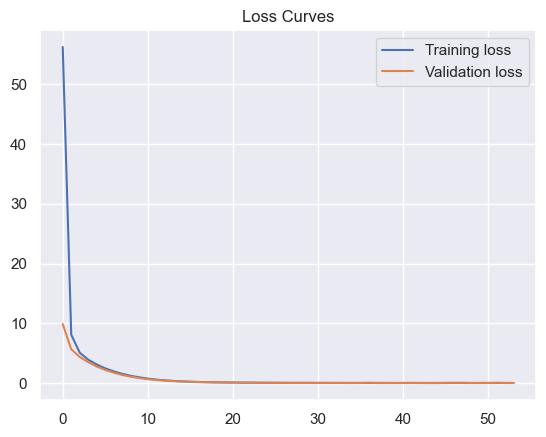

In [786]:
def create_model(learning_rate):
    model = None

    # Define model
    model = keras.Sequential()
    model.add(
        keras.layers.Dense(
            units=x_train.shape[1],
            activation="selu",
            input_dim=x_train.shape[1],
            kernel_regularizer=tf.keras.regularizers.l2(l2=0.1),
        ),
    )
    model.add(
        keras.layers.Dense(
            units=x_train.shape[1],
            activation="selu",
            kernel_regularizer=tf.keras.regularizers.l2(l2=0.1),
        )
    )

    model.add(keras.layers.Dense(units=1, activation="linear"))
    # Specify the optimizer using the TF API to specify the learning rate
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    return model


learning_rate = 0.01
epochs = 100
batch_size = 25
model = create_model(learning_rate)


earlystop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=10, verbose=0, mode="auto"
)

callbacks_list = [earlystop]

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
    callbacks=earlystop,
)
# Plot
my_module.showRegressionResults(trainHistory)

my_module.print_evaluate_regression(y1_test, np.expm1(model.predict(x_test)))

In [789]:
x_sub = df_final.loc[df["SalePrice"].isna()][for_prediction[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": np.expm1(pred)})
my_module.test_nulls(sub)
sub.to_csv("submission.csv", index=False)

59/59 [==============================] - 0s 1ms/step
Engineered features do not contain nulls.
